In [ ]:
import pandas as pd
import numpy as np
dataset_path = "chinese_mnist.csv"
df = pd.read_csv(dataset_path)
df.head(3)

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
import zipfile

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")


In [ ]:
import os

# Ver carpeta creada después de descomprimir
print(os.listdir("data/data/")[:10])

print("Cantidad de imágenes:", len(os.listdir("data/data")))


['input_45_8_8.jpg', 'input_7_3_2.jpg', 'input_100_2_8.jpg', 'input_63_10_5.jpg', 'input_75_6_15.jpg', 'input_29_2_15.jpg', 'input_24_7_7.jpg', 'input_58_1_8.jpg', 'input_83_3_10.jpg', 'input_79_1_14.jpg']
Cantidad de imágenes: 15000


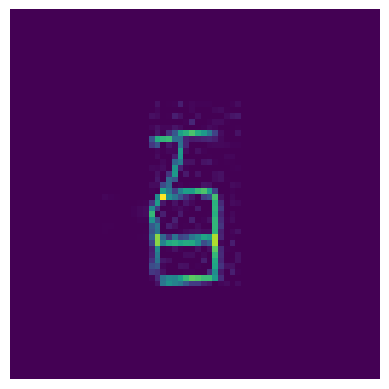

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
data_path = 'data/data/'
img_path = os.path.join(data_path, os.listdir(data_path)[14000])
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
df.character.unique()

array(['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六',
       '七', '八'], dtype=object)

Vincular cada imagen con su fila del CSV: Agregar la columna con el nombre del archivo

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

df["filename"] = "input_" + df["suite_id"].astype(str) + "_" \
                           + df["sample_id"].astype(str) + "_" \
                           + df["code"].astype(str) + ".jpg"

Crear 'X' (paths de imágenes) y 'y' (caracteres):

In [ ]:
import os
image_path = 'data/data'
X = [os.path.join(image_path, fname) for fname in df["filename"]]
y = df["character"].values

Verificamos:

In [ ]:
print("Ejemplo X[0]:", X[0])  # ruta de la primera imagen
print("Ejemplo y[0]:", y[0])  # etiqueta (ej: 九)


Ejemplo X[0]: data/data/input_1_1_10.jpg
Ejemplo y[0]: 九


X:  data/data/input_20_4_13.jpg
Y:  千


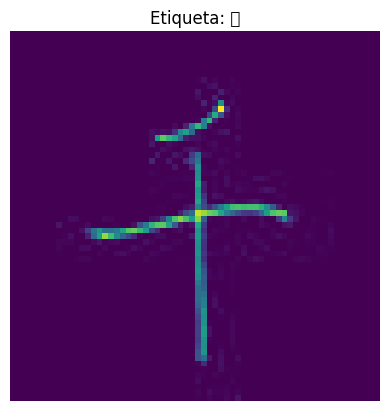

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(X[3134])
plt.imshow(img)
print("X: ", X[3134])
print("Y: ", y[3134])
plt.title(f"Etiqueta: {y[3134]}")
plt.axis("off")
plt.show()


X → son los paths de las imágenes (luego se convierten en tensores/matrices).

y → es el character, que es la variable objetivo a predecir.

Mapear las etiquetas (character) a números, ya que PyTorch no trabaja con strings como etiquetas y necesitamos índices enteros.

In [ ]:
import pandas as pd

y_idx, classes = pd.factorize(y)  # y_idx = números, classes = mapeo inverso
print("Número de clases:", len(classes))
print("Primeras clases:", classes[:10])
print("Numeros mapeados: ", y_idx)



Número de clases: 15
Primeras clases: ['九' '十' '百' '千' '万' '亿' '零' '一' '二' '三']
Numeros mapeados:  [ 0  0  0 ... 14 14 14]


**Dataset y Transformaciones con PyTorch**

En lugar de cargar todas las imágenes a memoria, lo mejor es definir un Dataset personalizado que cargue cada imagen cuando se necesita.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Definir transformaciones: resize y tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class ImageDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        label = self.y[idx]

        img = Image.open(img_path).convert("RGB")  # abrir imagen
        if self.transform:
            img = self.transform(img)

        return img, label


El siguiente paso es muy importante, consiste en separar los datos en 3 subconjuntos:
- **Entrenamiendo (train) (80%)**: Se usa para que el modelo aprenda los patrones de los datos.
- **Validacion (10%)**: Sirve para ajustar parámetros y evaluar el desempeño del modelo durante el entrenamiento, sin usar los datos de prueba.
- **Prueba (10%)**: Se reserva hasta el final para medir el rendimiento real del modelo en datos nunca vistos.

In [ ]:
from sklearn.model_selection import train_test_split
import random

# dividir en train (80%), val (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_idx, test_size=0.2, random_state=random.randint(0, 100)
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random.randint(0, 100)
)

**Crear datasets y dataloaders**

* **`ImageDataset`** es una clase que hereda de `torch.utils.data.Dataset`.

* Su función es **gestionar tus datos de manera ordenada**:

  * Sabe **cuántas imágenes hay** (`__len__`).
  * Sabe **cómo cargar una imagen y su etiqueta** (`__getitem__`).
  * Aplica transformaciones automáticamente (como resize, y  ToTensor).

* `X_train`, `X_val`, `X_test` → **rutas** a las imágenes.

* `y_train`, `y_val`, `y_test` → **etiquetas** correspondientes.

* `transform=transform` → aplica los pasos de **preprocesamiento** que definiste.

Resultado: cada `train_dataset`/`val_dataset`/`test_dataset` ahora es un **contenedor de datos listo para PyTorch**.

#### DataLoader

Hace varias cosas importantes:

1. **Crea batches**:

   * **`batch_size=64`** → devuelve 64 imágenes + 64 etiquetas por iteración.
   * Esto es más eficiente que pasar toda la dataset completa de una vez.

2. **Maneja el orden y el shuffle**:

   * **`shuffle=True`** en entrenamiento → mezcla los datos en cada época para que el modelo no aprenda un orden fijo.
   * `shuffle=False` en validación/test → el orden no importa, queremos reproducibilidad.

#### Resumen

* **Dataset** → “qué datos tenemos y cómo acceder a ellos”.
* **DataLoader** → “cómo entregar los datos al modelo en batches, en orden aleatorio si queremos”.



In [ ]:
from torch.utils.data import DataLoader

train_dataset = ImageDataset(X_train, y_train, transform=transform)
val_dataset   = ImageDataset(X_val, y_val, transform=transform)
test_dataset  = ImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


**Definir un modelo**

En PyTorch hablamos de **capas que tienen parámetros aprendibles** (weights/biases), aunque también consideramos **capas funcionales como ReLU o pooling.**

**Capas con parámetros:**

conv1 = nn.Conv2d(3, 32, 3, padding=1) → convolucional

conv2 = nn.Conv2d(32, 64, 3, padding=1) → convolucional

fc1 = nn.Linear(64*16*16, 128) → fully connected

fc2 = nn.Linear(128, num_classes) → fully connected

Total = 4 capas con parámetros

**Capas “funcionales” (sin parámetros):**


F.relu(...) → ReLU (activación)

self.pool(...) → MaxPooling (reducción de tamaño)

Si contás todas las transformaciones en forward, incluyendo activaciones y pooling:

Conv1 → 2. ReLU → 3. Pool → 4. Conv2 → 5. ReLU → 6. Pool → 7. FC1 → 8. ReLU → 9. FC2

Total de pasos en forward: 9, pero solo 4 tienen parámetros entrenables.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Definir modelo
model = SimpleCNN(num_classes=len(classes)).to(device)

In [ ]:
# Criterio y optimizador
perdida = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

Entrenamiento

In [ ]:
# Cantidad de épocas
num_epochs = 15
for epoch in range(num_epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = perdida(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = perdida(outputs, y_batch)
            val_loss += loss.item()

            # Calcular accuracy
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Métricas por época
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.2f}%")


Epoch [1/15] Train Loss: 0.1226 Val Loss: 0.2097 Val Acc: 94.53%
Epoch [2/15] Train Loss: 0.1361 Val Loss: 0.2189 Val Acc: 94.27%
Epoch [3/15] Train Loss: 0.1437 Val Loss: 0.2392 Val Acc: 93.93%
Epoch [4/15] Train Loss: 0.1445 Val Loss: 0.2588 Val Acc: 93.27%
Epoch [5/15] Train Loss: 0.1523 Val Loss: 0.2175 Val Acc: 94.73%
Epoch [6/15] Train Loss: 0.1491 Val Loss: 0.2142 Val Acc: 94.13%
Epoch [7/15] Train Loss: 0.1491 Val Loss: 0.2369 Val Acc: 94.67%
Epoch [8/15] Train Loss: 0.1497 Val Loss: 0.2381 Val Acc: 93.47%
Epoch [9/15] Train Loss: 0.1505 Val Loss: 0.2597 Val Acc: 93.53%
Epoch [10/15] Train Loss: 0.1549 Val Loss: 0.2066 Val Acc: 94.87%
Epoch [11/15] Train Loss: 0.1511 Val Loss: 0.2139 Val Acc: 95.13%
Epoch [12/15] Train Loss: 0.1517 Val Loss: 0.2613 Val Acc: 93.67%
Epoch [13/15] Train Loss: 0.1536 Val Loss: 0.2450 Val Acc: 93.60%
Epoch [14/15] Train Loss: 0.1501 Val Loss: 0.2372 Val Acc: 93.20%
Epoch [15/15] Train Loss: 0.1517 Val Loss: 0.2204 Val Acc: 95.40%


El paso final consiste en evaluar el modelo entreanado sobre el conjunto de datos de test

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report

# Evaluación en el set de test
y_true = []
y_pred = []

model.eval()  # modo evaluación
with torch.no_grad():
    for X_batch, true_y in test_loader:
        X_batch, true_y = X_batch.to(device), true_y.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(true_y.cpu().numpy())

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {accuracy:.4f}')

# Reporte de clasificación
# target_names los armamos como strings de los números
num_clases = len(set(y_true))  # detecta cuántas clases tenés
target_names = [str(i) for i in range(num_clases)]

print(classification_report(y_true, y_pred, target_names=target_names))


Accuracy on the test set: 0.9407
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        96
           1       0.95      0.93      0.94        99
           2       0.91      0.95      0.93        94
           3       0.94      0.95      0.94        98
           4       0.90      0.94      0.92        98
           5       0.90      0.94      0.92        97
           6       0.97      0.97      0.97       115
           7       0.95      1.00      0.97        93
           8       0.93      0.91      0.92       107
           9       0.92      0.93      0.92        95
          10       1.00      0.94      0.97        99
          11       0.97      0.93      0.95       103
          12       0.97      0.93      0.95        97
          13       0.95      0.93      0.94       100
          14       0.98      0.97      0.98       109

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94    

### Accuracy general

```
Accuracy on the test set: 0.9647
```

* La **exactitud** global es 96.47%.
* Esto significa que **el modelo predijo correctamente aproximadamente 964 de cada 1000 imágenes**.


### Tabla de métricas por clase

Cada fila corresponde a una clase (en tu caso los números `0,1,2,...,14`). Las columnas son:

* **precision** (precisión)

  Qué porcentaje de las predicciones que el modelo dijo que eran esa clase **fueron correctas**.

* **recall** (recuperación o sensibilidad)

  Qué porcentaje de **los verdaderos ejemplos de esa clase fueron detectados correctamente**.

* **f1-score**

  Es la media armónica de precisión y recall → balancea ambos.

* **support**
  Cantidad de ejemplos reales de esa clase en el test set.


### Promedios

* **accuracy** → 0.96 (ya lo vimos, precisión global).
* **macro avg** → promedio simple de precision, recall y f1-score entre todas las clases.
* **weighted avg** → promedio ponderado por la cantidad de ejemplos de cada clase (support), útil si algunas clases tienen más muestras que otras.
